<a href="https://colab.research.google.com/github/esnue/ThesisAllocationSystem/blob/main/contextualized_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


adapted from: https://github.com/MilaNLProc/contextualized-topic-models

## Contextualized Topic Models 

We are going to use contextualized topic modeling to get topics out of a supervisors' academic papers, student proposals and supervision plans.

## Topic Models 

Topic models allow you to discover latent topics in text documents in a completely unsupervised way. 

## Contextualized Topic Models

What are Contextualized Topic Models? **CTMs** are a family of topic models that combine the expressive power of BERT embeddings with the unsupervised capabilities of topic models to get topics out of documents.




# Enabling the GPU

First, you'll need to enable GPUs for the notebook. If GPU is not available, it will switch to CPU.

In [1]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'gpu'

# Installing Contextualized Topic Models

Now, we install the contextualized topic model library

In [2]:
%%capture
!pip install contextualized-topic-models==1.8.1
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

## Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

#academic papers
file1 = pd.read_csv("/content/drive/MyDrive/ThesisAllocationSystem/data_final/train-papers-final.csv")
#transform content column row values into a list
train_file = file1['Content'].values.tolist()

print(train_file[:5])
print(type(train_file))

#thesis proposals
file2 = pd.read_csv("/content/drive/MyDrive/ThesisAllocationSystem/data_final/test-proposals-final.csv")
test_file = file2['Content'].values.tolist()

print(test_file[2])
print(type(test_file))

#supervision plans
file3 = pd.read_csv("/content/drive/MyDrive/ThesisAllocationSystem/data_final/supervisors-final.csv")
val_file = file3['Content'].values.tolist()

print(val_file[5])
print(type(val_file))

["b'1 \\n \\n\\nCurry, D., Hammerschmid, G., Jilke, S., Van de Walle, S. (2015). Executive Perceptions of Public Sector \\n\\nReform in Europe. In: Massey, A. & Johnston, K. (eds). International Handbook of Public \\n\\nAdministration and Governance. Cheltenham: Edward Elgar. Pp. 369-398. \\n\\n \\n\\nThe State and Perceptions of Public Sector Reform in Europe1 \\n\\nDion Curry, Gerhard Hammerschmid, Sebastian Jilke, Steven Van de Walle \\n\\nLike most other areas of the world, the public sector in Europe has undergone significant reform in \\n\\nthe past two decades, shaped in part by a broader New Public Management (NPM) paradigm, but \\n\\none that also introduces a unique European flavour to this form of public management. Whilst NPM \\n\\nand public administration in Europe shares similarities with other cases, the added complexity of \\n\\ndiffering starting points and the EU layer provide interesting insight into the nature of public \\n\\nadministration. This chapter will draw 

## Importing what we need

For some reasons it gives an error when the cell runs at first time, just try again and it should work.

In [5]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_list, TopicModelDataPreparation
from contextualized_topic_models.datasets.dataset import CTMDataset
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts
from gensim.models import ldamodel 
#from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
import nltk
import os
import pickle

## Preprocessing

Let's pass our file with preprocess data to our text handler object. This object takes care of creating the bag of words for you.

Why do we use the **preprocessed text** here? we need text without punctuation to build the bag of word. Also, we might want only to have the most frequent words inside the BoW. Too many words might not help.

#### Train data

Due to publisher layout and other "noisy" words we need to eliminate more stopwords than are included in nltk stopwords.

In [49]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/ThesisAllocationSystem')

In [51]:
from WPpreprocessing import WhiteSpacePreprocessing

NameError: ignored

In [45]:
nltk.download('stopwords')

documents = train_file

sp = WhiteSpacePreprocessing(documents, "english")
train_preprocessed_documents_for_bow, train_unpreprocessed_corpus_for_contextual, vocab = sp.preprocess()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


You might want to pickle the **training_dataset** object to avoid recomputing the BoW multiple times

In [8]:
qt = TopicModelDataPreparation("bert-base-nli-mean-tokens")

training_dataset = qt.create_training_set(train_unpreprocessed_corpus_for_contextual, train_preprocessed_documents_for_bow)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
#pickle the training dataset
with open('training.pickle', 'wb') as f:
    pickle.dump(training_dataset, f)

## Training our Contextualized Topic Model

Finally, we can fit our new topic model. We will ask the model to find 28 topics in our collection (n_component parameter of the CTM object), equal to number of supervisors

In [10]:
ctm = CombinedTM(input_size=len(qt.vocab), bert_input_size=768, n_components=28, num_epochs=20)

ctm.fit(training_dataset) 

Epoch: [20/20]	 Seen Samples: [16220/16220]	Train Loss: 13027.929408138101	Time: 0:00:00.412312: : 20it [00:08,  2.48it/s]


## Saving the Model

In [11]:
path = F"/content/drive/MyDrive/ThesisAllocationSystem/models/ctm.bin" 
ctm.save(path)

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/models/ctm.py:388: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  Warning)


## Loading the Model 

In [12]:
#del ctm

Q HANNAH: how to open saved model

In [13]:
#ctm = CombinedTM(input_size=len(qt.vocab), bert_input_size=768, num_epochs=100, n_components=50)

#ctm.load("/content/drive/MyDrive/ThesisAllocationSystem/models/ctm.bin/, epoch = 14)

Loading from Colab directory doesn't seem to work. 

# Topics

After training, now it is the time to look at our topics: we can use the 

```
get_topic_lists
```

function to get the topics. It also accepts a parameter that allows you to select how many words you want to see for each topic.

If you look at the topics, you will see that they all make sense and are representative of a collection of documents that comes from Wikipedia (general knowledge).

In [14]:
ctm.get_topic_lists(20)

[['firms',
  'firm',
  'sample',
  'results',
  'level',
  'use',
  'size',
  'time',
  'higher',
  'data',
  'women',
  'paper',
  'across',
  'first',
  'high',
  'table',
  'however',
  'number',
  'age',
  'section'],
 ['party',
  'election',
  'voters',
  'group',
  'parties',
  'model',
  'et',
  'groups',
  'al',
  'vote',
  'use',
  'two',
  'one',
  'conflict',
  'nwe',
  'used',
  'sample',
  'results',
  'data',
  'ethnic'],
 ['nn',
  'net',
  'nin',
  'na',
  'ng',
  'ns',
  'ne',
  'nd',
  'nb',
  'diffusion',
  'publicationcoverpdf',
  'nm',
  'nro',
  'np',
  'nh',
  'nu',
  'ner',
  'enrichsource',
  'nt',
  'nhttps'],
 ['random',
  'nwere',
  'vote',
  'embedded',
  'simply',
  'correlation',
  'ngovernments',
  'kayser',
  'peoples',
  'sometimes',
  'estimated',
  'frequently',
  'nsome',
  'failure',
  'enrichsource',
  'effort',
  'demonstrate',
  'designed',
  'constant',
  'modern'],
 ['market',
  'price',
  'power',
  'costs',
  'electricity',
  'prices',
  'mar

We see that most topics are coherent, however the input data needs further cleaning during preprocessing, to avoid topics such as `['nu', 'nn', 'nm', 'na', 'ne']`

### Let's find the papers' topics

Ok now we can take a document and see which topic has been asigned to it.  For example, let's predict the topic of the first preprocessed document.

In [15]:
topics_predictions = ctm.get_doc_topic_distribution(training_dataset, n_samples=20) # get all the topic predictions

Sampling: [20/20]: : 20it [00:07,  2.78it/s]


In [16]:
train_preprocessed_documents_for_bow[0] # see the text of the first preprocessed document

'van de executive perceptions public sector europe eds international public governance pp nthe state perceptions public sector reform van de areas world public sector europe significant reform nthe past two decades shaped part broader new public management npm none also unique european form public management npm nand public administration europe shares cases added complexity starting points eu provide nature public chapter draw large scale survey top european executives central ngovernment order develop comprehensive perceptions npm reforms ntheir effects last five years focusing cross selection eu countries nthe chapter present findings choice policy instruments relevance different reform general success impact within case countries nthe chapter first provide general overview state public sector european ncountries study public sector reform perceived top focus key trends public sector terms npm post npm including usage different policy instruments trends regarding transparency cooper

In [17]:
import numpy as np
topic_number = np.argmax(topics_predictions[0]) # get the topic id of the first document
topic_number

5

In [18]:
ctm.get_topic_lists(20)[topic_number] #and the topic should and could be about public management related things

['data',
 'sector',
 'public',
 'countries',
 'analysis',
 'reforms',
 'country',
 'used',
 'performance',
 'use',
 'text',
 'different',
 'results',
 'management',
 'number',
 'health',
 'based',
 'level',
 'administration',
 'et']

### Visualization of a topic

We can visualize `topic 5`, which is our first document's topic id. We want the wordcloud to display 20 words of the topic.

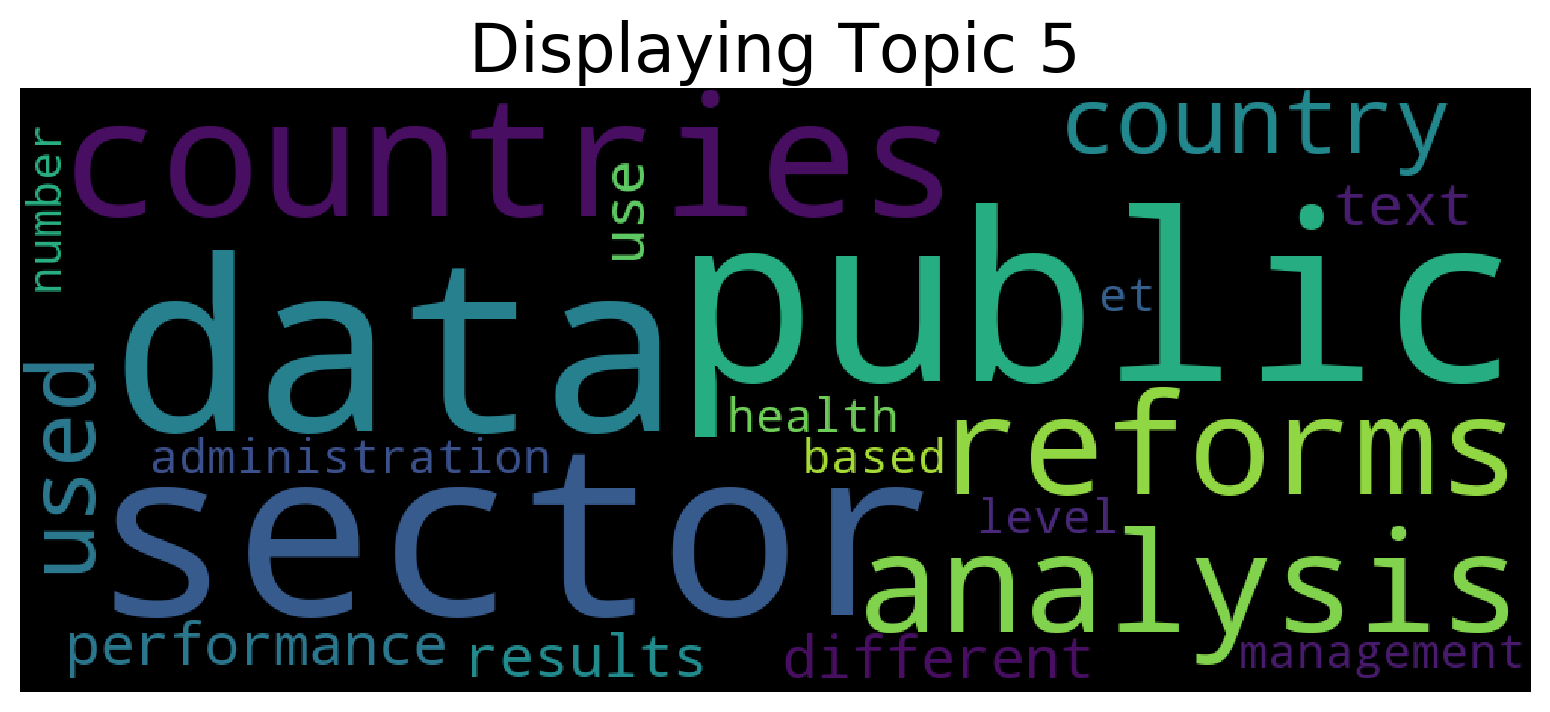

In [31]:
ctm.get_wordcloud(topic_id=topic_number, n_words=20)

In [32]:
print(type(topics_predictions))
print(len(topics_predictions))


#workaround, number of test files available
docs =  list(range(811))

topic_id = []
topic_labels = []
#get all topic ids for each document in the train data set
for doc in docs: 
    topic_index = np.argmax(topics_predictions[doc])
    topic_id.append(topic_index)
    topic = ctm.get_topic_lists(20)[topic_index]
    topic_labels.append(topic)

#this list contains the topic ids for all test documents
topic_id
print(len(topic_id))
# this list contains the labels for all test documents given their respective topic id
topic_labels

<class 'numpy.ndarray'>
811
811


[['data',
  'sector',
  'public',
  'countries',
  'analysis',
  'reforms',
  'country',
  'used',
  'performance',
  'use',
  'text',
  'different',
  'results',
  'management',
  'number',
  'health',
  'based',
  'level',
  'administration',
  'et'],
 ['actors',
  'organizations',
  'public',
  'nand',
  'society',
  'management',
  'civil',
  'role',
  'particular',
  'research',
  'making',
  'many',
  'business',
  'policy',
  'institutional',
  'social',
  'different',
  'process',
  'activities',
  'understanding'],
 ['random',
  'nwere',
  'vote',
  'embedded',
  'simply',
  'correlation',
  'ngovernments',
  'kayser',
  'peoples',
  'sometimes',
  'estimated',
  'frequently',
  'nsome',
  'failure',
  'enrichsource',
  'effort',
  'demonstrate',
  'designed',
  'constant',
  'modern'],
 ['data',
  'sector',
  'public',
  'countries',
  'analysis',
  'reforms',
  'country',
  'used',
  'performance',
  'use',
  'text',
  'different',
  'results',
  'management',
  'number',
  

We are using the created topics with each 20 words to contain test data content, but without the inherent bias coming from writing style and word choice. Furthermore, we could use either the topic ids or the professors as labels which we then plan to input into a distilBERT classifier model. 

In [33]:
import pandas as pd

train_label_df = pd.DataFrame()

train_label_df["prof"] = file1["FileName"]
train_label_df["topic_id"] = topic_id
train_label_df["topic"] = topic_labels

train_label_df.to_csv('/content/drive/MyDrive/ThesisAllocationSystem/data_final/ctm_label/train-label.csv', index = False)

# Test

We are using the test set to predict for unseen documents. 

In [34]:
documents = test_file

sp = WhiteSpacePreprocessing(documents, "english")
test_preprocessed_documents_for_bow, test_unpreprocessed_corpus_for_contextual, vocab = sp.preprocess()

/usr/local/lib/python3.7/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [23]:
testing_dataset = qt.create_test_set(test_unpreprocessed_corpus_for_contextual, test_preprocessed_documents_for_bow) # create dataset for the testset
predictions = ctm.get_doc_topic_distribution(testing_dataset, n_samples=10)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling: [10/10]: : 10it [00:01,  5.66it/s]


In [24]:
print(test_unpreprocessed_corpus_for_contextual[3])

topic_index = np.argmax(predictions[3])
ctm.get_topic_lists(20)[topic_index]

b'Master_Thesis_Proposal\n\n\nMaster Thesis Proposal \n\nClass: 2021 \n\nAY: 2020-2021\n\n\n1. What is your research topic?\n\nTopic: Forecasting election results of federal and state-level elections in Germany using \ndifferent machine learning techniques with macro-economic data as input.\n\nAcademic Fields: \n1. Political Science:\n-> Political behavior and voting\n-> Election forecasting\n2. Data Science: \n-> Machine Learning \n-> Artificial neural networks\n\n2. What is your research question?\n\nWhat role do changes in the over all economy of an election district play regarding the \napproval, i.e. the vote share, of an incumbent direct-candidate in the respective election \ndistrict. To analyze the factors that actually have the biggest influence on the vote share of \nan incumbent candidate, several macro-economic variables are analyzed using different \nmachine learning techniques (potentially including neural networks). \n\nStudied objects: \n- General elections from 1994-20

['computer',
 'cause',
 'frequently',
 'sometimes',
 'nearly',
 'ngovernments',
 'nwould',
 'absence',
 'nnon',
 'demonstrate',
 'forces',
 'extend',
 'south',
 'seem',
 'explained',
 'summary',
 'essential',
 'calls',
 'led',
 'comprehensive']

Topics seem to show mixed validity here, might be due to shortness of the proposal text as well as the small sample size. Hopefully this will improve

In [25]:
print(type(topics_predictions))
#print(topics_predictions)

print(len(test_file))

#workaround, number of test files available
docs =  list(range(6))

topic_id = []
topic_labels = []
#get all topic ids for each document in the test data set
for doc in docs: 
    topic_index = np.argmax(topics_predictions[doc])
    topic_id.append(topic_index)
    topic = ctm.get_topic_lists(20)[topic_index]
    topic_labels.append(topic)

#this list contains the topic ids for all test documents
topic_id
# this list contains the labels for all test documents given their respective topic id
topic_labels


<class 'numpy.ndarray'>
6


[['data',
  'sector',
  'public',
  'countries',
  'analysis',
  'reforms',
  'country',
  'used',
  'performance',
  'use',
  'text',
  'different',
  'results',
  'management',
  'number',
  'health',
  'based',
  'level',
  'administration',
  'et'],
 ['actors',
  'organizations',
  'public',
  'nand',
  'society',
  'management',
  'civil',
  'role',
  'particular',
  'research',
  'making',
  'many',
  'business',
  'policy',
  'institutional',
  'social',
  'different',
  'process',
  'activities',
  'understanding'],
 ['random',
  'nwere',
  'vote',
  'embedded',
  'simply',
  'correlation',
  'ngovernments',
  'kayser',
  'peoples',
  'sometimes',
  'estimated',
  'frequently',
  'nsome',
  'failure',
  'enrichsource',
  'effort',
  'demonstrate',
  'designed',
  'constant',
  'modern'],
 ['data',
  'sector',
  'public',
  'countries',
  'analysis',
  'reforms',
  'country',
  'used',
  'performance',
  'use',
  'text',
  'different',
  'results',
  'management',
  'number',
  

In [26]:
test_label_df = pd.DataFrame()

test_label_df['proposal'] = file2['FileName']
test_label_df["topic_id"] = topic_id
test_label_df["topic"] = topic_labels
test_label_df

test_label_df.to_csv('/content/drive/MyDrive/ThesisAllocationSystem/data_final/ctm_label/test-label.csv', index = False)

Eventually, we might need to change the column `proposal` with the top preference of supervisor to perform matching.

## Validation

We are using the supervision plans to predict for topics that professors offer their students to write their thesis about.

In [27]:
documents = val_file

sp = WhiteSpacePreprocessing(documents, "english")
val_preprocessed_documents_for_bow, val_unpreprocessed_corpus_for_contextual, vocab = sp.preprocess()

/usr/local/lib/python3.7/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [28]:
validation_dataset = qt.create_test_set(val_unpreprocessed_corpus_for_contextual, val_preprocessed_documents_for_bow) # create dataset for the test set
predictions = ctm.get_doc_topic_distribution(validation_dataset, n_samples=10)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling: [10/10]: : 10it [00:01,  5.45it/s]


In [29]:
print(val_unpreprocessed_corpus_for_contextual[4])

topic_index = np.argmax(predictions[3])
ctm.get_topic_lists(20)[topic_index]

b'MIA/MPP - Supervision Plan AY2020/2021        1 \n\n \n \n\nMaster Thesis Supervision Plan \nAcademic Year 2020-2021 \n\nMIA/MPP \n \n\nName: S\xe9bastien Mena \n\nProfessor of Organization & Governance \n\n  \nAdvisor Information  \n\nOffice 1.41.1 \n\nE-Mail mena@hertie-school.org \n\nFaculty Assistant Alwine Hoppe (hoppe@hertie-school.org, room 3.10) \n\nOffice Hours Appointment by email \n\n \n \nResearch & Advising Profile: \nGeneral Academic Field: What is your academic field, and what are your areas of supervision? \n\nAcademic Field: Management and Organization Studies \n\nAreas of supervision: In general, any topic taking an organizational sociology perspective (e.g. \norganization theory, organizational change, organizational behavior, etc.) or looking at the role \nof business in society (Business Ethics, Corporate Social Responsibility, Corporate/Business \nSustainability, etc.).  \n\n \n\nSpecific Expertise: What is your specific area of expertise, and what topics are yo

['computer',
 'cause',
 'frequently',
 'sometimes',
 'nearly',
 'ngovernments',
 'nwould',
 'absence',
 'nnon',
 'demonstrate',
 'forces',
 'extend',
 'south',
 'seem',
 'explained',
 'summary',
 'essential',
 'calls',
 'led',
 'comprehensive']

Again, little topic validity, worse than with test data. Probably due to shortness of relevant text

# Evaluation

In [30]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI

#with train_preprocessed_documents_for_bow as fr:
texts = [line.split() for line in train_preprocessed_documents_for_bow] # load text for NPMI

npmi = CoherenceNPMI(texts=texts, topics=ctm.get_topic_lists(10))
npmi.score()

0.06478317161921857

# Perform Matching